In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D,
    Flatten, LSTM, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model


2026-01-07 14:33:22.761948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767796402.948700      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767796403.005803      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767796403.452880      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767796403.452928      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767796403.452931      55 computation_placer.cc:177] computation placer alr

In [2]:
dataset_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50"


In [3]:
MAX_VIDEOS_PER_CLASS = 50   


In [4]:
motion_map = {
    "BenchPress": "STABLE",
    "CleanAndJerk": "STABLE",
    "MilitaryParade": "STABLE",
    "TaiChi": "STABLE",
    
    "WalkingWithDog": "SMOOTH",
    "HorseRiding": "SMOOTH",
    "Rowing": "SMOOTH",
    "Kayaking": "SMOOTH",
    "Skiing": "SMOOTH",
    "Skijet": "SMOOTH",

    "JumpRope": "REPETITIVE",
    "JumpingJack": "REPETITIVE",
    "PushUps": "REPETITIVE",
    "PullUps": "REPETITIVE",
    "SoccerJuggling": "REPETITIVE",
    "JugglingBalls": "REPETITIVE",
    "HulaHoop": "REPETITIVE",
    "Drumming": "REPETITIVE",

    "GolfSwing": "SHARP",
    "TennisSwing": "SHARP",
    "BaseballPitch": "SHARP",
    "Punch": "SHARP",
    "Fencing": "SHARP",
    "ThrowDiscus": "SHARP",
    "JavelinThrow": "SHARP",
    "VolleyballSpiking": "SHARP",
    "HighJump": "SHARP",
    "PoleVault": "SHARP",

    "SkateBoarding": "UNSTABLE",
    "TrampolineJumping": "UNSTABLE",
    "Biking": "UNSTABLE",
    "RockClimbingIndoor": "UNSTABLE",
    "RopeClimbing": "UNSTABLE",
    "PommelHorse": "UNSTABLE",
    "SalsaSpin": "UNSTABLE"
}


In [5]:
selected_classes = list(motion_map.keys())

primitive_classes = sorted(set(motion_map.values()))
primitive_to_idx = {p: i for i, p in enumerate(primitive_classes)}
idx_to_primitive = {i: p for p, i in primitive_to_idx.items()}

print("Motion primitives:", primitive_to_idx)


Motion primitives: {'REPETITIVE': 0, 'SHARP': 1, 'SMOOTH': 2, 'STABLE': 3, 'UNSTABLE': 4}


In [6]:
missing = []
for cls in selected_classes:
    if not os.path.exists(os.path.join(dataset_path, cls)):
        missing.append(cls)

print("Missing classes:", missing)


Missing classes: []


In [7]:
def extract_frames(video_path, num_frames=20):
    frames = []
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    interval = max(total_frames // num_frames, 1)

    count = 0
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if count % interval == 0:
            frame = cv2.resize(frame, (64, 64))
            frame = frame / 255.0
            frames.append(frame)

        count += 1

    cap.release()

    while len(frames) < num_frames:
        frames.append(frames[-1])

    return np.array(frames)


In [8]:
X, y = [], []

for cls in selected_classes:
    class_path = os.path.join(dataset_path, cls)
    videos = os.listdir(class_path)[:MAX_VIDEOS_PER_CLASS]

    for video in videos:
        video_path = os.path.join(class_path, video)
        frames = extract_frames(video_path)

        if frames.shape == (20, 64, 64, 3):
            X.append(frames)
            y.append(primitive_to_idx[motion_map[cls]])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class distribution:", Counter(y))


X shape: (1750, 20, 64, 64, 3)
y shape: (1750,)
Class distribution: Counter({np.int64(1): 500, np.int64(0): 400, np.int64(4): 350, np.int64(2): 300, np.int64(3): 200})


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1767796480.170718      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


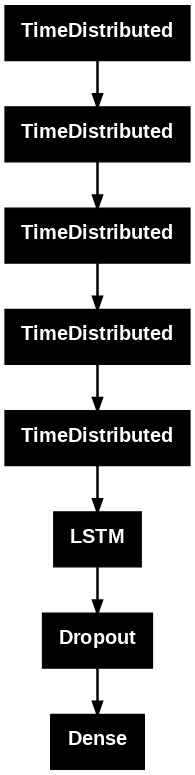

In [10]:
model = Sequential()

model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'),
    input_shape=(20, 64, 64, 3)
))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.5))

model.add(Dense(len(primitive_classes), activation='softmax'))

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

plot_model(model, dpi=90)


In [11]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=4,
    validation_data=(X_test, y_test)
)


Epoch 1/10


I0000 00:00:1767796489.531500    7124 cuda_dnn.cc:529] Loaded cuDNN version 91002


350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.2381 - loss: 1.6729 - val_accuracy: 0.4171 - val_loss: 1.3994
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.3754 - loss: 1.4227 - val_accuracy: 0.4914 - val_loss: 1.2873
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5072 - loss: 1.2276 - val_accuracy: 0.5200 - val_loss: 1.2240
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.5731 - loss: 1.0900 - val_accuracy: 0.5286 - val_loss: 1.2067
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.6116 - loss: 0.9849 - val_accuracy: 0.5800 - val_loss: 1.1027
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7284 - loss: 0.7495 - val_accuracy: 0.5829 - val_loss: 1.0923
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7696 - loss: 0.6816 - val_accuracy: 0.6086 - val_loss: 1.0906
Epoch 8/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8068 - loss: 0.5912 - val_accuracy: 0.62

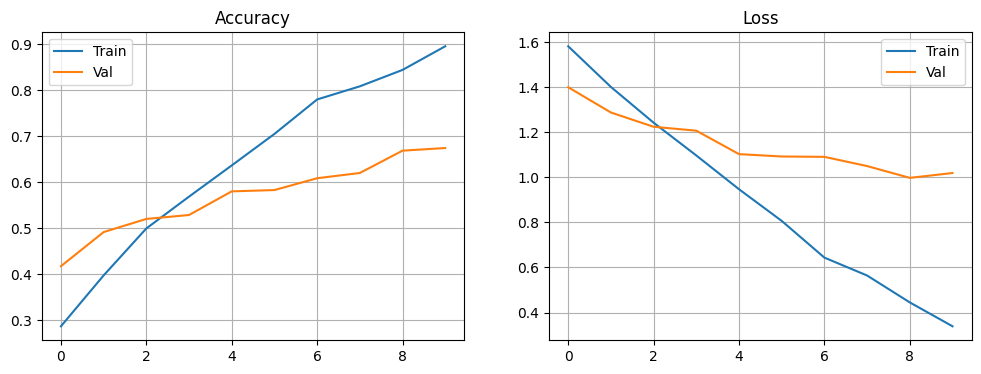

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()


In [13]:
def compute_behavior_metrics(pred_label):
    return {
        "Stability Score": 1.0 if pred_label == "STABLE" else 0.0,
        "Restlessness Index": 1.0 if pred_label in ["REPETITIVE", "SHARP"] else 0.0
    }


In [14]:
def interpret_behavior(label):
    if label == "STABLE":
        return "Stable and composed motion pattern."
    elif label == "REPETITIVE":
        return "Repetitive motion detected (possible restlessness)."
    elif label == "SHARP":
        return "Sharp movements detected."
    elif label == "UNSTABLE":
        return "High motion variability detected."
    else:
        return "Smooth continuous motion observed."


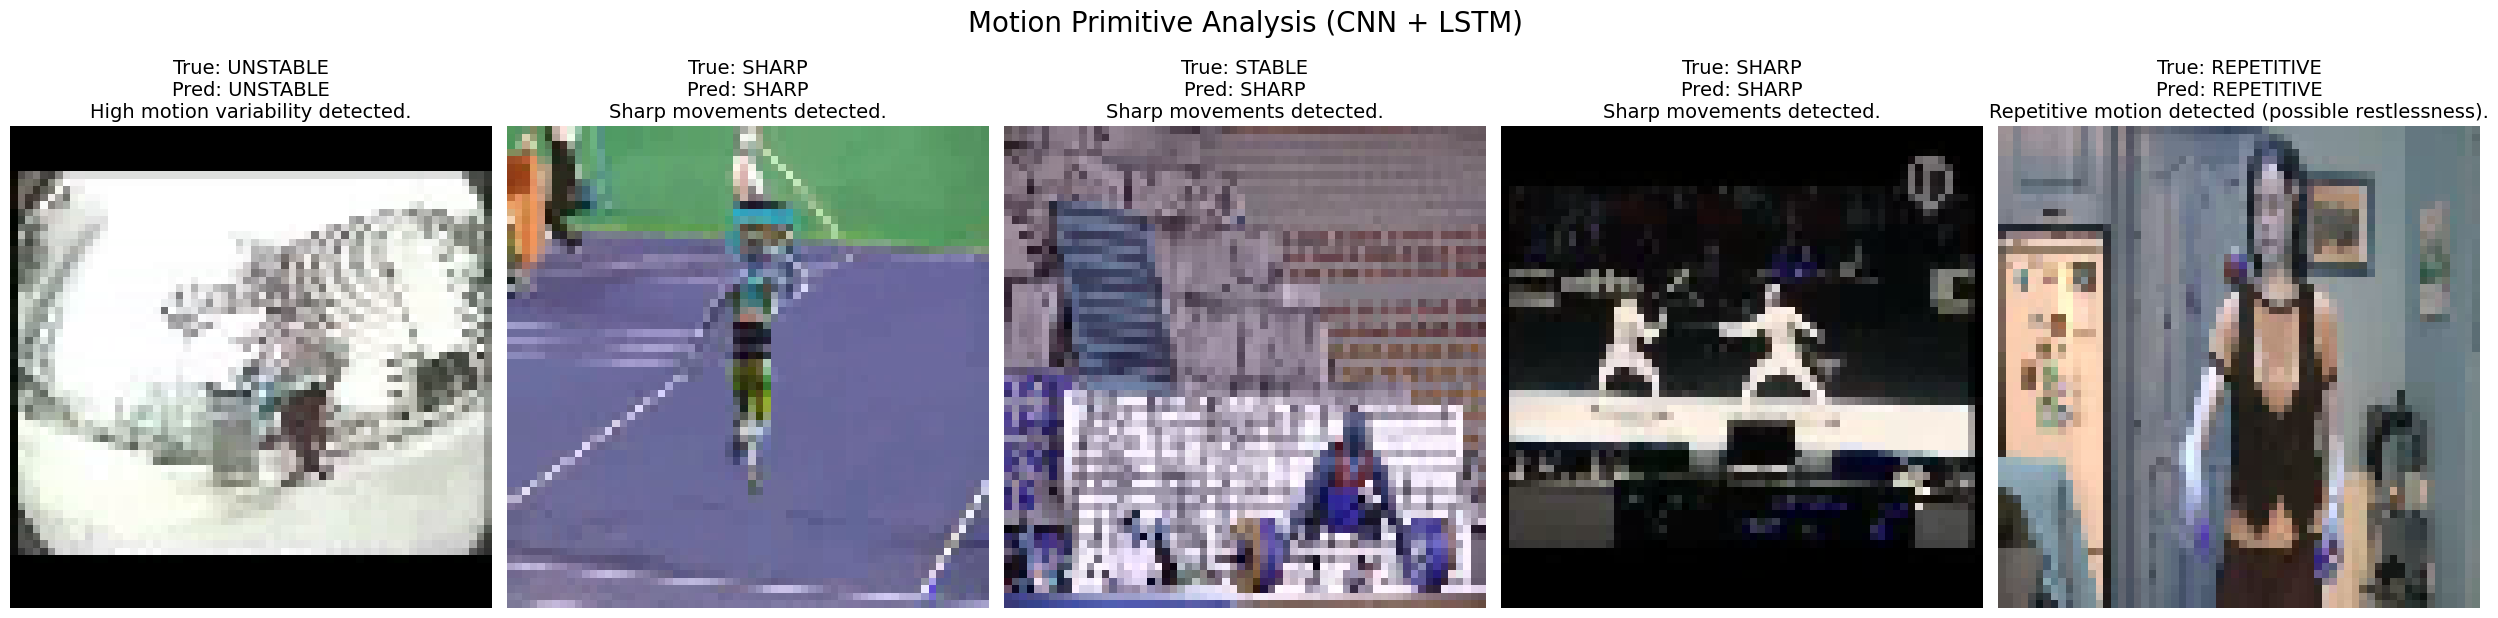

In [15]:
def show_predictions(model, X_test, y_test):
    indices = np.random.choice(len(X_test), 5, replace=False)

    fig, axes = plt.subplots(1, 5, figsize=(25, 7))

    for i, idx in enumerate(indices):
        video = X_test[idx]
        true_label = idx_to_primitive[y_test[idx]]

        pred = model.predict(np.expand_dims(video, axis=0), verbose=0)
        pred_label = idx_to_primitive[np.argmax(pred)]

        frame = (video[10] * 255).astype(np.uint8)

        axes[i].imshow(frame)
        axes[i].set_title(
            f"True: {true_label}\nPred: {pred_label}\n{interpret_behavior(pred_label)}",
            fontsize=14
        )
        axes[i].axis('off')

    plt.suptitle("Motion Primitive Analysis (CNN + LSTM)", fontsize=20)
    plt.tight_layout()
    plt.show()

show_predictions(model, X_test, y_test)
